GDP stands for gross domestic product, which is meant to represent the total dollar value of all goods and services produced over a specific period of time. The CPI, which stands for consumer price index, is a measure of a theoretical basket of goods meant to represent what people are buying. The predetermined basket of goods is averaged and the goods are weighted against one anther based on how important they are to a household. According to investopedia.com, the CPI indicates whether the economy is experiencing inflation, deflation or stagflation. GDP and CPI are, therefore, closely related, though there are some differences.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [ ]:
# Connect to google drive
in_colab = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Capstone/Project_1")  
    in_colab = True
except:
    pass

Mounted at /content/drive


In [ ]:
# Loading the data
df = pd.read_excel("Data/Raw/Section2All_xls.xlsx", sheet_name = 'T20405-A')
gdp_df = pd.read_excel("Data/Raw/Section1All_xls.xlsx", sheet_name = 'T10105-A')
# df.head(8)

### Parse the Excel File

In [ ]:
# Convert column types to int
# Column could be actual characters or nan
def convert_col_type(col_name):
    try:
        col_name = int(col_name)
    except:
        pass 

    return col_name


# Remove parentheses from column names
def remove_parentheses(label):
    return re.sub("[\(\[].*?[\)\]]", "", label)


# Parse excel files and clean the data
def parse_excel_file(df):
    first_col = df.columns[0]
    top_row = df.index[df[first_col] == 'Line'].tolist()[0]

    # Remove headers
    df = df[top_row:].reset_index(drop=True) 
    df_columns = df.iloc[0].apply(convert_col_type)
    df.columns = df_columns
    df = df.drop(0).reset_index(drop=True)
    
    # Convert to list
    try:
        first_blank = df.index[df['Line'].isna()].tolist()[0]
        df = df.iloc[:first_blank]
    except:
        pass

    # Dataframe has years as columns and features as rows - transpose to opposite
    rotated_df = df.T
    column_labels = rotated_df.iloc[1]

    # Format labels
    column_labels = [remove_parentheses(i) for i in column_labels]
    column_labels = [x.strip() for x in column_labels]
    rotated_df.columns = column_labels
    # rotated_df.head(7)

    df = rotated_df.reset_index().rename(columns={0: 'Year'}, errors='ignore')
    # df['Year'] = df['Year'].astype(int)
    vals = list(df['Year'])
    year_rows = [i for i in range(len(vals)) if type(vals[i]) == int]
    df = df[year_rows[0]:]

    return df 


df = parse_excel_file(df)
gdp_df = parse_excel_file(gdp_df)

In [ ]:
# Joining CPI data
def join_cpi_data(df):
    cpi_data_html = pd.read_html('https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/')


    cpi_data_df = cpi_data_html[0]
    cpi_columns = cpi_data_df.iloc[1]

    cpi_data_df = cpi_data_df[2:]
    cpi_data_df.columns = cpi_columns
    cpi_data_df['Year'] = cpi_data_df['Year'].astype(int)
    cpi_data_df['Avg'] = cpi_data_df['Avg'].astype(float)

    df = pd.merge(df, cpi_data_df, how='left', on='Year')

    return df


df = join_cpi_data(df)
gdp_df = join_cpi_data(gdp_df)

In [ ]:
# https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
def get_recessions(first_year, last_year):
    recessions = [(1929, 1933, 26.7),
                (1937, 1938, 18.2),
                (1945, 1945, 12.7),
                (1948, 1949, 1.7),
                (1953, 1954, 2.6),
                (1957, 1958, 3.7),
                (1960, 1961, 1.6),
                (1969, 1970, 0.6),
                (1973, 1975, 3.2),
                (1980, 1980, 2.2),
                (1981, 1982, 2.7),
                (1990, 1991, 1.4),
                (2001, 2001, 0.3),
                (2007, 2009, 5.1),
                (2020, 2020, 19.2)]

    within_timeframe = []
    
    # Find time frames
    for recession in recessions:
        if recession[0] <= last_year and recession[1] > first_year:
            within_timeframe.append(recession)

    return within_timeframe


def remove_missing_data(df, y_var):
    valid_years_df = df[df[y_var] != "....."]

    return valid_years_df

In [ ]:
from matplotlib.ticker import StrMethodFormatter


def plot_timeline(df, y_var, spending_or_gdp, label_points = True):
    plt.style.use('ggplot')

    df = remove_missing_data(df, y_var)
    
    first_year = df['Year'].min()
    last_year = df['Year'].max()

    recessions = get_recessions(first_year, last_year)
    ax1_x_ticks = [i for i in range(first_year, last_year, 5)]

    min_cpi = int(df['Avg'].min())
    max_cpi = int(df['Avg'].max())

    cpi_spread = max_cpi - min_cpi

    if cpi_spread > 60:
        ax2_y_ticks = [i for i in range(int(df['Avg'].min()), int(df['Avg'].max()), 20)]
    else:
        ax2_y_ticks = [i for i in range(int(df['Avg'].min()), int(df['Avg'].max()), 5)]
    
    if ax1_x_ticks[-1] != last_year:
        ax1_x_ticks.append(last_year)

    fig, ax1 = plt.subplots(figsize=(12,6)) 
    ax1.plot(df['Year'], df[y_var], color='green', label = y_var)
    
    if label_points:
        for recession in recessions:
            starting_point = recession[0]
            ending_point = recession[1]

            if starting_point == ending_point:
                ax1.axvline(x = starting_point, color = 'red', alpha = recession[2])
            else:
                ax1.axvspan(starting_point, ending_point, color = 'red', alpha=recession[2])

    ax2 = ax1.twinx() 
    ax2.plot(df['Year'], df['Avg'], color = 'black', label='Consumer Price Index')  

    if spending_or_gdp == 'spending':
        plt.suptitle(f"Spending on {y_var} in millions of dollars".title(), fontsize = 14)
        plt.title("Red shading indicates period of recession corresponding to magnitude of shading", fontsize = 12, y = 1)
        ax1.set_ylabel(f"Spending on {y_var}".title())
        ax2.set_ylabel(f"Consumer Price Index", rotation=270, labelpad=15)

    if spending_or_gdp == 'gdp':
        plt.suptitle(f"Gross Domestic Product on {y_var} in millions of dollars".title(), fontsize = 14)
        plt.title("Red shading indicates period of recession corresponding to magnitude of shading", fontsize = 12, y = 1)
        ax1.set_ylabel(f"GDP for {y_var}".title())
        ax2.set_ylabel(f"Consumer Price Index", rotation=270, labelpad=15)

    ax1.set_xticks(ax1_x_ticks)
    ax2.set_yticks(ax2_y_ticks)

    ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

    ax2.grid(False)

    fig.autofmt_xdate(rotation=45)

    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')
    # plt.savefig(f"{y_var}.png", dpi=100)
    plt.show()

In [ ]:
def plot_year_subset(df, year_start, year_end, y_var, spending_or_gdp):
    first_year_index = df.index[df['Year'] == year_start][0]
    last_year_index = df.index[df['Year'] == year_end][0]

    df = df[first_year_index: last_year_index].reset_index(drop=True)

    return plot_timeline(df, y_var, spending_or_gdp)

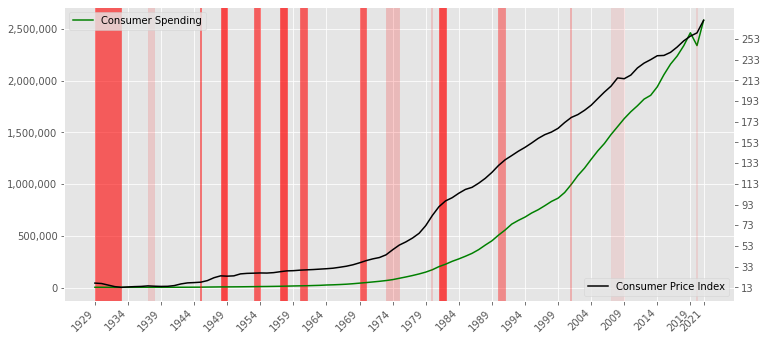

In [ ]:
plot_timeline(df, 'Health care')

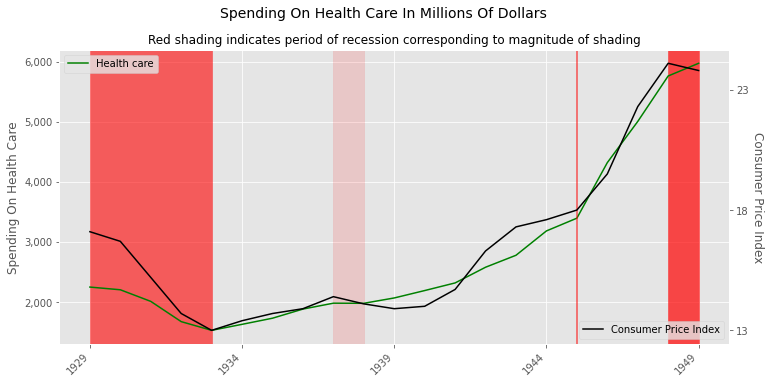

In [ ]:
plot_year_subset(df, 1929, 1950, 'Health care', 'spending')

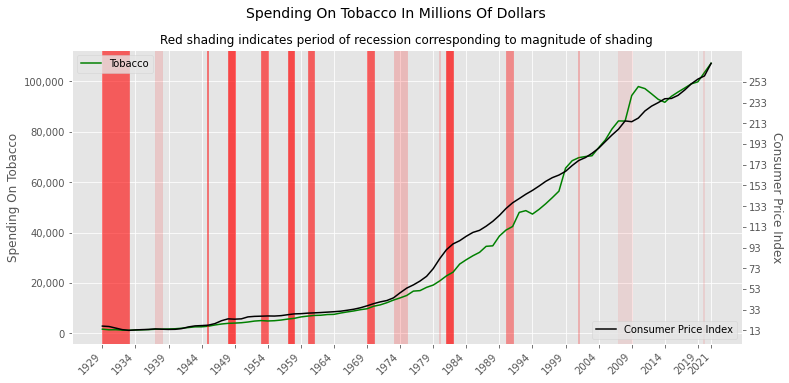

In [ ]:
plot_timeline(df, 'Tobacco', 'spending')

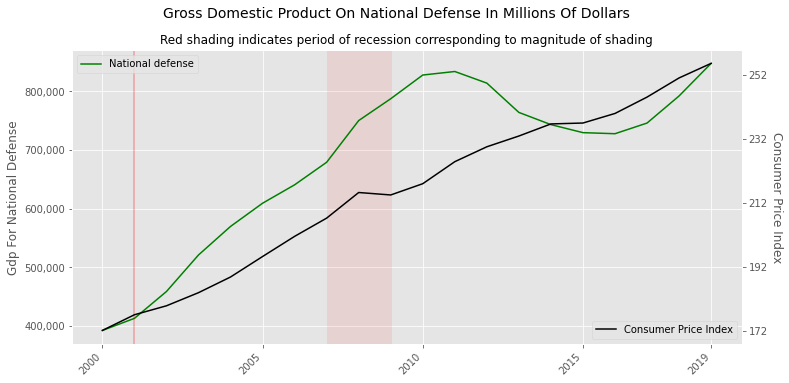

In [ ]:
plot_year_subset(gdp_df, 2000, 2020,'National defense', 'gdp')

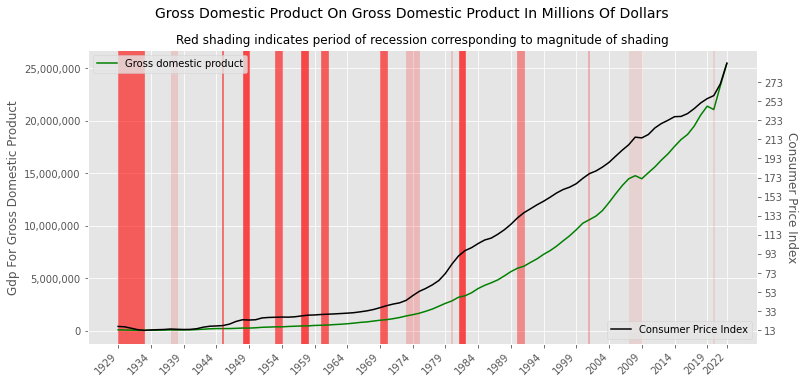

In [ ]:
plot_timeline(gdp_df, 'Gross domestic product', 'gdp')

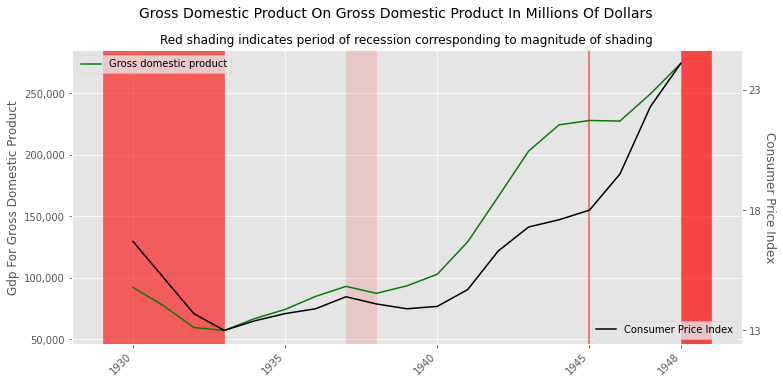

In [ ]:
plot_year_subset(gdp_df, 1930, 1949, 'Gross domestic product', 'gdp')

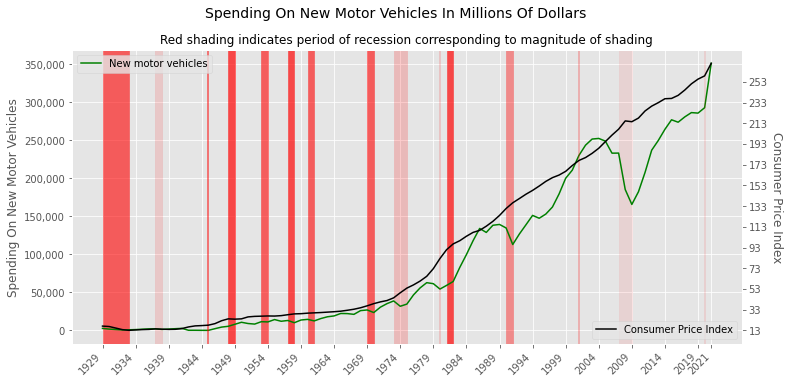

In [ ]:
plot_timeline(df, 'New motor vehicles', 'spending')

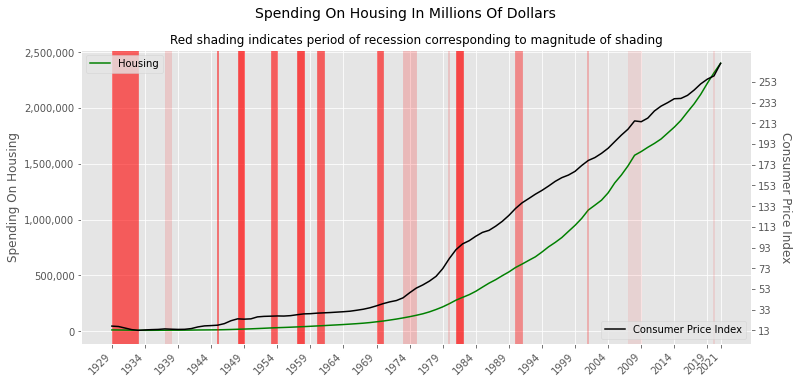

In [ ]:
plot_timeline(df, 'Housing', 'spending')

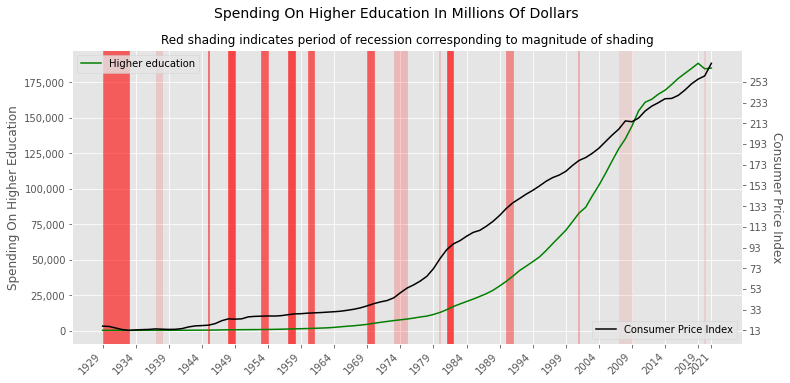

In [ ]:
plot_timeline(df, 'Higher education', 'spending')

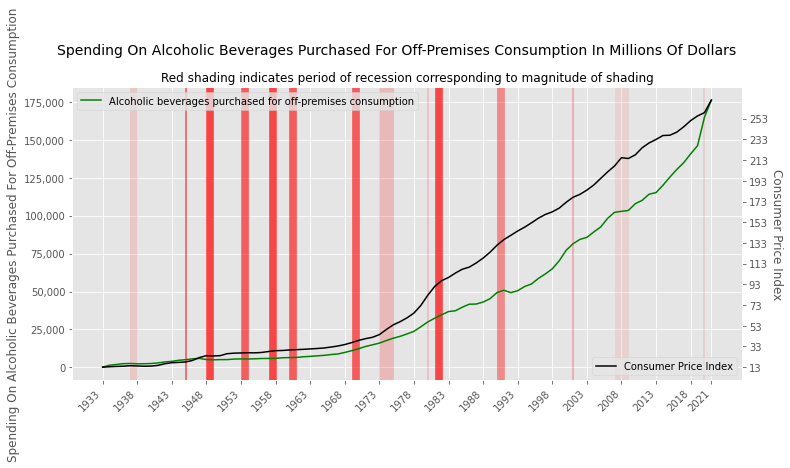

In [ ]:
plot_timeline(df, 'Alcoholic beverages purchased for off-premises consumption', 'spending')

## Old Code

In [ ]:
# from matplotlib.ticker import StrMethodFormatter

# def plot_gdp_timeline(df, y_var, label_points = True):
#     plt.style.use('ggplot')

#     df = remove_missing_data(df, y_var)
    
#     first_year = df['Year'].min()
#     last_year = df['Year'].max()

#     recessions = get_recessions(first_year, last_year)

#     ax1_x_ticks = [i for i in range(first_year, last_year, 5)]
#     ax2_y_ticks = [i for i in range(int(df['Avg'].min()), int(df['Avg'].max()), 20)]
    
#     if ax1_x_ticks[-1] != last_year:
#         ax1_x_ticks.append(last_year)

#     fig, ax1 = plt.subplots(figsize=(12,6)) 
    
#     ax1.plot(df['Year'], df[y_var], color='green', label = y_var)
    
#     if label_points:
#         for recession in recessions:
#             starting_point = recession[0]
#             ending_point = recession[1]

#             if starting_point == ending_point:
#                 ax1.axvline(x = starting_point, color = 'red', alpha = recession[2])
#             else:
#                 ax1.axvspan(starting_point, ending_point, color = 'red', alpha=recession[2])

#     ax2 = ax1.twinx() 
#     ax2.plot(df['Year'], df['Avg'], color = 'black', label='Consumer Price Index')  

#     # plt.suptitle(f"Gross Domestic Product on {y_var} in millions of dollars".title(), fontsize = 14)
#     # plt.title("Red shading indicates period of recession corresponding to magnitude of shading", fontsize = 12, y = 1)

#     ax1.set_xticks(ax1_x_ticks)
#     ax2.set_yticks(ax2_y_ticks)

#     ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#     ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

#     # ax1.set_ylabel(f"GDP for {y_var}".title())
#     # ax2.set_ylabel(f"Consumer Price Index", rotation=270, labelpad=15)
    
#     ax2.grid(False)

#     fig.autofmt_xdate(rotation=45)

#     ax1.legend(loc='upper left')
#     ax2.legend(loc='lower right')
#     plt.savefig(f"{y_var}.png", dpi=100)
#     plt.show()


# def plot_gdp_year_subset(df, year_start, year_end, y_var):

#     first_year_index = df.index[df['Year'] == year_start][0]
#     last_year_index = df.index[df['Year'] == year_end][0]

#     df = df[first_year_index: last_year_index].reset_index(drop=True)

#     return plot_gdp_timeline(df, y_var)

In [ ]:
# test = pd.read_html("https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States")
# test[2]

# cpi_data_df.to_excel("Data/CPI_Monthly.xlsx")